### NLP要解决的任务：

- 1.处理文本数据，首先对文本数据进行分词操作(分词的方法可能会不同，中文常见的就是分词或者分字)
- 2.分完的词它不还是字符嘛，计算机还不认识，最终我们希望把这些字符映射成实际的特征（向量）
- 3.输入搞定好了之后，接下来咱们要构建模型了（一般都用预训练模型，例如BERT,GPT系列等）
- 4.怎么去完成我们自己的任务呢，基本上就是在预训练模型的基础上进行微调（训练我们自己数据的过程）

### 先来瞅瞅多简单就干了一个大活
- Huggingface这个包基本上就是调用即可，开箱即用的过程

In [1]:
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline#用人家设计好的流程完成一些简单的任务
classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

如果遇到 'tensorflow_core.keras.activations' has no attribute 'swish' 注释掉即可
- D:\ProgramData\Anaconda3\lib\site-packages\transformers\activations_tf.py


### 基本流程概述分析


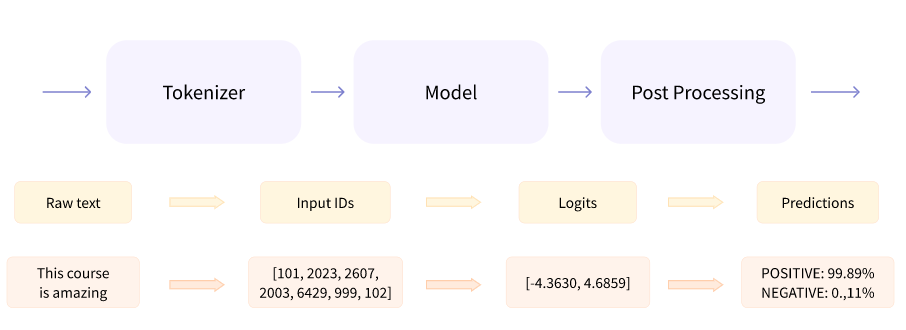


### Tokenizer要做的事：
- 分词，分字以及特殊字符（起始，终止，间隔，分类等特殊字符可以自己设计的）
- 对每一个token映射得到一个ID（每个词都会对应一个唯一的ID）
- 还有一些辅助信息也可以得到，比如当前词属于哪个句子（还有一些MASK，表示是否事原来的词还是特殊字符等）

In [2]:
from transformers import AutoTokenizer#自动判断

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"#根据这个模型所对应的来加载
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
raw_inputs = [
    "I've been waiting for a this course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 1045, 5223, 2023, 2061, 2172,  999,  102,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


In [4]:
tokenizer.decode([ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,2166, 1012,  102])

"[CLS] i've been waiting for a this course my whole life. [SEP]"

这些特殊字符是因为人家模型训练的时候就加入了这个东西，所以这里默认也加入了

### 模型的加载方法与很简单
- 直接指定好名字即可，这里我们先不加输出层

In [2]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [29]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 15, 768])


### 模型基本逻辑

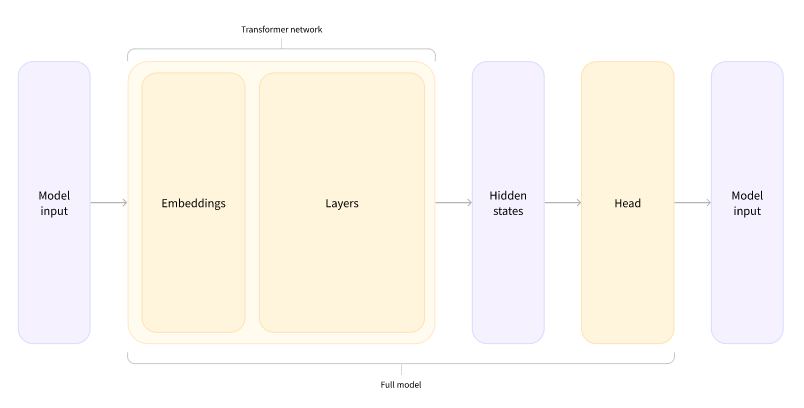

### 输出头我们也可以一并加上

In [8]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([2, 2])


In [9]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [10]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[1.5446e-02, 9.8455e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


id2label这个我们后续可以自己设计，标签名字对应都可以自己指定

In [11]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

### padding的作用

In [33]:
sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]

batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)

print(model(torch.tensor(batched_ids)).logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


为啥结果会不一样呢？

### attention_mask的作用

In [34]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


### 不同的padding方法

In [35]:
sequences = ["I've been waiting for a this course my whole life.", "So have I!", "I played basketball yesterday."]

In [36]:
# 按照最长的填充
model_inputs = tokenizer(sequences, padding="longest")
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2209, 3455, 7483, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [37]:
# BERT默认最大是512
model_inputs = tokenizer(sequences, padding="max_length")
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
# 填充到多少
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0], [101, 1045, 2209, 3455, 7483, 1012, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0]]}

In [42]:
#到多少就截断
model_inputs = tokenizer(sequences, max_length=10, truncation=True)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 102], [101, 2061, 2031, 1045, 999, 102], [101, 1045, 2209, 3455, 7483, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}

In [43]:
#最好返回tensor
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")
model_inputs

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 2061, 2031, 1045,  999,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [ 101, 1045, 2209, 3455, 7483, 1012,  102,    0,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}